### Lecture 1

#### Environment Setup

In [1]:
!python -V

/usr/bin/sh: 1: python: not found


In [2]:
!python3 -V

Python 3.7.3


In [3]:
!python3 -m pip install https://download.pytorch.org/whl/cu100/torch-1.1.0-cp36-cp36m-linux_x86_64.whl --user

torch-1.1.0-cp36-cp36m-linux_x86_64.whl is not a supported wheel on this platform.


In [5]:
!python3 -m pip install https://download.pytorch.org/whl/cu100/torchvision-0.3.0-cp36-cp36m-linux_x86_64.whl --user

In [1]:
import torch
import torchvision


print(torch.__version__)
print(torchvision.__version__)
print(torch.cuda.is_available())

1.1.0
0.3.0
True


#### Bonus Tip


##### Jupyter Notebook Remote Server

##### Terminal Only
`
$ jupyter notebook --port 8888 --no-browser --ip 0.0.0.0
`

#### Windows Troubleshooting

Reference: <a href="https://pytorch.org/docs/stable/notes/windows.html" target="_BLANK">WINDOWS FAQ</a>

#### LeNet-5 Architecture

In [1]:
import torch


class LeNet5(torch.nn.Module):
    
    def __init__(self):
        
        super(LeNet5, self).__init__()
        
        self.convnet = torch.nn.Sequential(
            # Conv Block 1
            torch.nn.Conv2d(
                in_channels=1,
                out_channels=6,
                kernel_size=(5, 5),
                stride=1,
                bias=True
            ),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(
                kernel_size=(2, 2),
                stride=2
            ),
            # Conv Block 2
            torch.nn.Conv2d(
                in_channels=6,
                out_channels=16,
                kernel_size=(5, 5),
                stride=1,
                bias=True
            ),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(
                kernel_size=(2, 2),
                stride=2
            ),
            # Conv Block 3
            torch.nn.Conv2d(
                in_channels=16,
                out_channels=120,
                kernel_size=(5, 5),
                stride=1,
                bias=True
            ),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(
                kernel_size=(2, 2),
                stride=2
            )
        )
        
        self.fcn = torch.nn.Sequential(
            # Fully Connected Layer 1
            torch.nn.Linear(
                in_features=120,
                out_features=84,
                bias=True
            ),
            torch.nn.ReLU(),
            # Classifier Layer 2
            torch.nn.Linear(
                in_features=84,
                out_features=10,
                bias=True
            ),
            torch.nn.Softmax(dim=1)
        )

    def forward(self, batch):
        ret = self.convnet(batch)
        ret = ret.view(batch.size(0), -1)
        ret = self.fcn(ret)
        return ret

#### Visualize Network ( Bonus )

In [2]:
! python3 -m pip install graphviz hiddenlayer --user

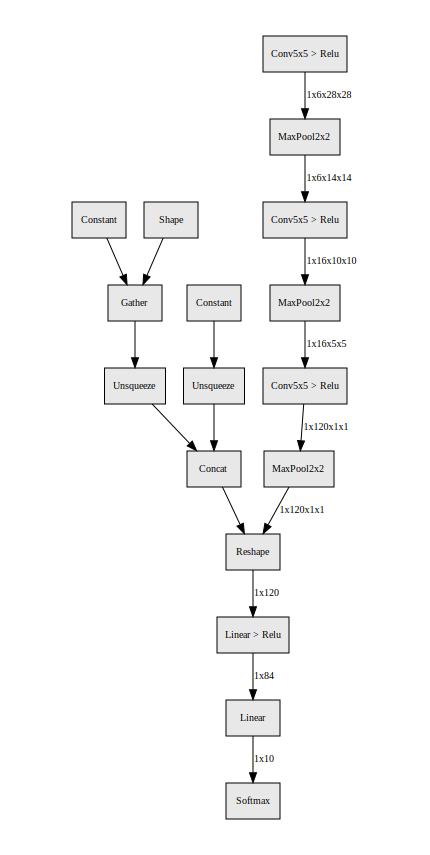

In [4]:
import hiddenlayer


hiddenlayer.build_graph(LeNet5(), torch.zeros(1, 1, 32, 32))

<i>Reference</i>: <a href="https://github.com/waleedka/hiddenlayer">HiddenLayer Documentation</a>

### Lecture 2

In [60]:
import numpy as np
import torch.nn.functional as F

In [61]:
inputs = torch.from_numpy(
            np.array(
                [
                    [0, 0],
                    [0, 1],
                    [1, 0],
                    [1, 1]
                ],
                dtype=np.float32
            )
        )

outputs = torch.from_numpy(
            np.array(
                [
                    0,
                    1,
                    1,
                    0
                ],
                dtype=np.float32
            )
        )

weights = torch.randn(1, 2)
weights.requires_grad = True

bias = torch.randn(1, requires_grad=True)

In [62]:
F.linear(inputs, weights, bias)

tensor([[-0.1457],
        [ 0.4265],
        [-0.0445],
        [ 0.5277]], grad_fn=<AddmmBackward>)

In [63]:
preds = F.linear(inputs, weights, bias)
loss = (outputs - preds).mean()

In [64]:
preds.grad_fn

In [65]:
loss.grad_fn

In [66]:
weights.grad

In [67]:
loss.backward()

In [68]:
weights.grad

tensor([[-0.5000, -0.5000]])

### Lecture 3

#### MNIST Dataset

In [90]:
import torchvision

In [91]:
data_train = torchvision.datasets.MNIST(
    './data/mnist',
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.Pad(2),
        torchvision.transforms.ToTensor()
    ])
)

data_test = torchvision.datasets.MNIST(
    './data/mnist',
    train=False,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.Pad(2),
        torchvision.transforms.ToTensor()
    ])
)

In [106]:
BATCH_SIZE = 32
train_loader = torch.utils.data.DataLoader(
    data_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4
)

test_loader = torch.utils.data.DataLoader(
    data_test,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4
)

#### GPU Support

In [107]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')


device

device(type='cuda')

#### Cauchy-Schwarz Divergence

In [219]:
def encodeOneHot(torch_tensor):
    a = torch_tensor.cpu().numpy()
    
    b = np.zeros( ( a.size, 10 ) )
    
    b[ np.arange(a.size), a ] = 1

    return torch.from_numpy(b).float().to(device)


class CSD(torch.nn.Module):
    
    def __init__(self):
        
        super(CSD, self).__init__()
    
    def forward(self, outputs, target):
        
        y = encodeOneHot(target)
                
        nom = torch.sum(torch.mm(outputs, y.t()), dim=1)
        
        denom = torch.norm(outputs, 2) * torch.norm(y, 2)
        
        return torch.mean(-1 * torch.log(nom / denom))

#### Model Training

In [244]:
network = LeNet5().to(device)
optimizer = torch.optim.Adam(network.parameters(), lr=0.0005)
criterion = CSD()

In [245]:
epochs = 128
steps = len(train_loader) // BATCH_SIZE

network.train(True)

for e in range(epochs):
    
    epoch_loss = 0

    performed_steps = 0
    
    for i, (images, labels) in enumerate(train_loader):
        
        if i == steps:
            break
        
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = network(images)
        
        loss = criterion(outputs, labels)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss
        
        performed_steps += 1
    
    assert performed_steps == steps, "steps: {} != {}".format(steps, performed_steps)
    
    print("Epoch: {}, Loss: {:0.4f}".format(
        e + 1,
        epoch_loss / steps
    ))


Epoch: 1, Loss: 1.1541
Epoch: 2, Loss: 1.1528
Epoch: 3, Loss: 1.1498
Epoch: 4, Loss: 1.1530
Epoch: 5, Loss: 1.1518
Epoch: 6, Loss: 1.1510
Epoch: 7, Loss: 1.1509
Epoch: 8, Loss: 1.1485
Epoch: 9, Loss: 1.1516
Epoch: 10, Loss: 1.1512
Epoch: 11, Loss: 1.1523
Epoch: 12, Loss: 1.1494
Epoch: 13, Loss: 1.1483
Epoch: 14, Loss: 1.1481
Epoch: 15, Loss: 1.1491
Epoch: 16, Loss: 1.1511
Epoch: 17, Loss: 1.1523
Epoch: 18, Loss: 1.1503
Epoch: 19, Loss: 1.1491
Epoch: 20, Loss: 1.1483
Epoch: 21, Loss: 1.1509
Epoch: 22, Loss: 1.1499
Epoch: 23, Loss: 1.1490
Epoch: 24, Loss: 1.1473
Epoch: 25, Loss: 1.1493
Epoch: 26, Loss: 1.1489
Epoch: 27, Loss: 1.1476
Epoch: 28, Loss: 1.1510
Epoch: 29, Loss: 1.1487
Epoch: 30, Loss: 1.1483
Epoch: 31, Loss: 1.1480
Epoch: 32, Loss: 1.1475
Epoch: 33, Loss: 1.1489
Epoch: 34, Loss: 1.1489
Epoch: 35, Loss: 1.1455
Epoch: 36, Loss: 1.1491
Epoch: 37, Loss: 1.1495
Epoch: 38, Loss: 1.1489
Epoch: 39, Loss: 1.1491
Epoch: 40, Loss: 1.1494
Epoch: 41, Loss: 1.1466
Epoch: 42, Loss: 1.1504
E

#### Model Evaluation

In [246]:
avg_loss = 0
avg_acc = 0

network.train(False)

with torch.no_grad():
    
    steps = 0

    for images, labels in test_loader:
        
        images, labels = images.to(device), labels.to(device)

        outputs = network(images)

        avg_loss += criterion(outputs, labels)

        _, preds = torch.max(outputs, 1)
        avg_acc += preds.eq(labels).sum().item()
        
        steps += 1


print("Loss: {:0.2f}, Acc: {:.2%}".format(
    avg_loss / steps,
    avg_acc / (steps * BATCH_SIZE)
))

Loss: 1.15, Acc: 92.20%


### Read More

<ul>
    <li>Robert Jenssen, Jose C. Principe, Deniz Erdogmus, Torbjørn Eltoft, The Cauchy–Schwarz divergence and Parzen windowing: Connections to graph theory and Mercer kernels, Journal of the Franklin Institute, Volume 343, Issue 6, 2006, Pages 614-629, ISSN 0016-0032, https://doi.org/10.1016/j.jfranklin.2006.03.018.</li>
    <li>Jenssen, R., Eltoft, T., Erdogmus, D. et al. J VLSI Sign Process Syst Sign Image Video Technol (2006) 45: 49. https://doi.org/10.1007/s11265-006-9771-8</li>
    <li>Janocha, K., & Czarnecki, W. (2017). On Loss Functions for Deep Neural Networks in Classification. CoRR, abs/1702.05659.</li>
    <li>Lecun, Yann & Bottou, Leon & Bengio, Y & Haffner, Patrick. (1998). Gradient-Based Learning Applied to Document Recognition. Proceedings of the IEEE. 86. 2278 - 2324. 10.1109/5.726791. http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf </li>
</ul>

#### Course Discussions

Slack Channel: <a href="https://mqubits.slack.com/join/shared_invite/enQtNjU2MTQ3ODgxMjY3LTgyMGM3MzFjOTQ3OTdlYjVmMGJkZWI0NzgxNDAyNzEzYWVlNjQwOGQ5ZmY0MzFiYjc5OGNkZmY3YzQ5M2RhOWM">https://mqubits.slack.com/join/shared_invite/enQtNjU2MTQ3ODgxMjY3LTgyMGM3MzFjOTQ3OTdlYjVmMGJkZWI0NzgxNDAyNzEzYWVlNjQwOGQ5ZmY0MzFiYjc5OGNkZmY3YzQ5M2RhOWM</a>

#### Google Colab

<a href="https://colab.research.google.com/drive/1BON2RGHeRqS1tM3raz6HSpO8Xfz5-vYy">https://colab.research.google.com/drive/1BON2RGHeRqS1tM3raz6HSpO8Xfz5-vYy</a>